<a href="https://colab.research.google.com/github/Amitkumar664/WasteSeg-MiniProject/blob/kaushal/AI_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
data_dir = '/content/drive/MyDrive/archive/TrashType_Image_Dataset'

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True
)

# ✅ Training Generator
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# ✅ Validation Generator
val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
print(train_gen.class_indices)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
y_train = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weights_dict)

# 🧪 Custom Generator with Sample Weights
def weighted_generator(generator, class_weights_dict):
    while True:
        x_batch, y_batch = next(generator)
        sample_weights = np.array([class_weights_dict[int(label)] for label in y_batch])
        yield x_batch, y_batch, sample_weights

train_gen_with_weights = weighted_generator(train_gen, class_weights_dict)

Class Weights: {np.int32(0): np.float64(1.04437564499484), np.int32(1): np.float64(0.8412302576891105), np.int32(2): np.float64(1.0284552845528456), np.int32(3): np.float64(0.7086834733893558), np.int32(4): np.float64(0.8739205526770294), np.int32(5): np.float64(3.066666666666667)}


In [ ]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ❄️ Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# 🔓 Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ⚙️ Compile
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 🛑 Callbacks
early = EarlyStopping(patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_model.keras', save_best_only=True)

# 🚀 Training
steps_per_epoch = len(train_gen)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 1,691,142 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
history = model.fit(
    train_gen_with_weights,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early, checkpoint]
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 833s 13s/step - accuracy: 0.2353 - loss: 1.8578 - val_accuracy: 0.3598 - val_loss: 1.6452
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 612ms/step - accuracy: 0.4293 - loss: 1.4928 - val_accuracy: 0.4930 - val_loss: 1.3728
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 631ms/step - accuracy: 0.5780 - loss: 1.2660 - val_accuracy: 0.5646 - val_loss: 1.2153
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.6184 - loss: 1.1294 - val_accuracy: 0.5924 - val_loss: 1.1200
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.6690 - loss: 0.9863 - val_accuracy: 0.6083 - val_loss: 1.0623
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 587ms/step - accuracy: 0.7240 - loss: 0.9180 - val_accuracy: 0.6421 - val_loss: 0.9632
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 480ms/step - accuracy: 0.7343 - loss: 0.7974 - val_accuracy: 0.6779 - val_loss: 0.9065
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.7611 - loss: 0.7595 - val_accur

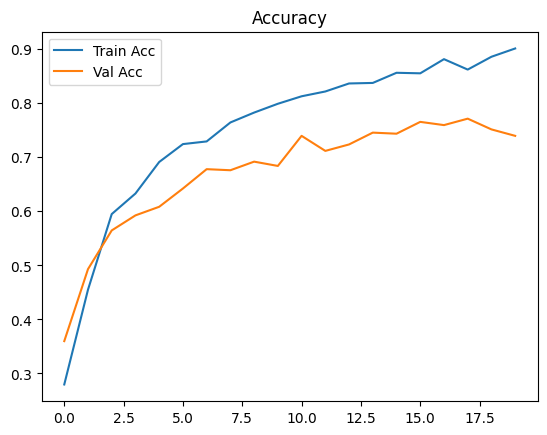

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
model.save('models/waste_model.keras')

# Load from .keras
model = keras.models.load_model('models/waste_model.keras', compile=False)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save .tflite
with open("models/waste_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpsre20kq_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135003672320464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003375109136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003375109520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003375110288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003375109712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003238470224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003238470800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003238472720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003238469072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003238471568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135003238466000

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 726ms/step
Classification Report:

              precision    recall  f1-score   support

   cardboard       0.89      0.95      0.92        80
       glass       0.78      0.80      0.79       100
       metal       0.95      0.63      0.76        82
       paper       0.87      0.75      0.81       118
     plastic       0.61      0.78      0.68        96
       trash       0.44      0.59      0.51        27

    accuracy                           0.77       503
   macro avg       0.76      0.75      0.75       503
weighted avg       0.80      0.77      0.78       503



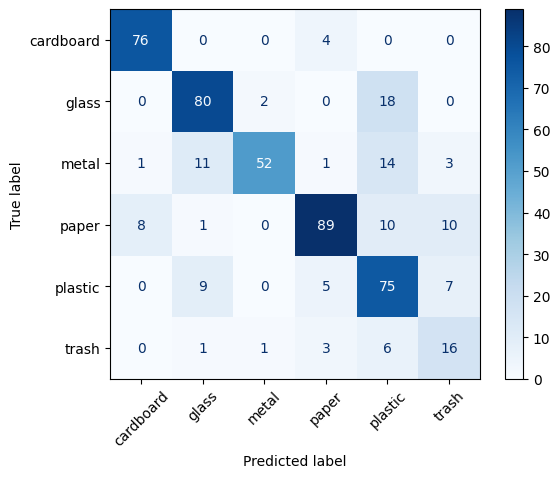

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# ✅ Load model (if not already loaded)
model = load_model('models/waste_model.keras')

# ✅ Predict on validation set
val_gen.reset()  # Ensures correct label order
Y_true = val_gen.classes
Y_pred = model.predict(val_gen, verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# ✅ Class labels
class_labels = list(val_gen.class_indices.keys())

# 📋 Print classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

# ✅ Optional: Show confusion matrix as well
cm = confusion_matrix(Y_true, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)

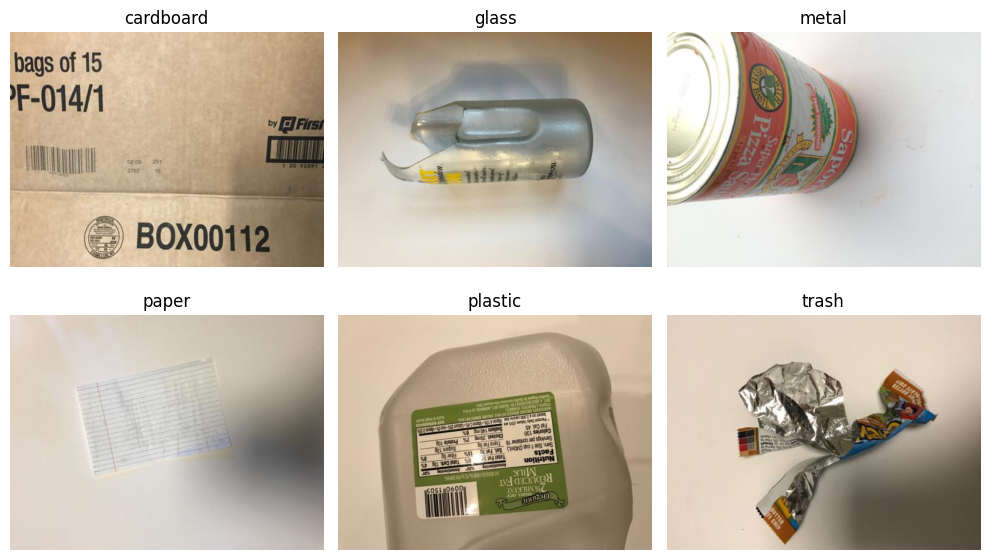

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2

# Update categories to match the actual class folders found by ImageDataGenerator
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
dataset_path = '/content/drive/MyDrive/archive/TrashType_Image_Dataset'

plt.figure(figsize=(10, 6))

for i, category in enumerate(categories):
    folder = os.path.join(dataset_path, category)
    # Check if the folder actually exists before trying to list its contents
    if not os.path.exists(folder):
        print(f"Warning: Directory not found for category: {category}. Skipping.")
        continue

    # Ensure the folder is not empty before trying to access the first element
    image_names = os.listdir(folder)
    if not image_names:
        print(f"Warning: No images found in directory: {folder}. Skipping.")
        continue

    image_name = image_names[0]
    img_path = os.path.join(folder, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

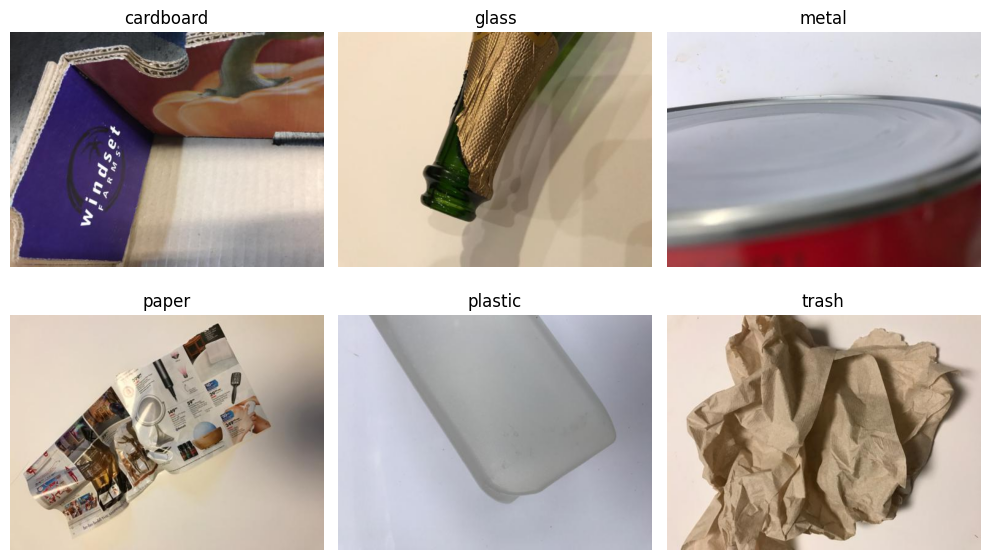

In [ ]:
plt.figure(figsize=(10, 6))

for i, category in enumerate(categories):
    folder = os.path.join(dataset_path, category)
    image_name = os.listdir(folder)[10]
    img_path = os.path.join(folder, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

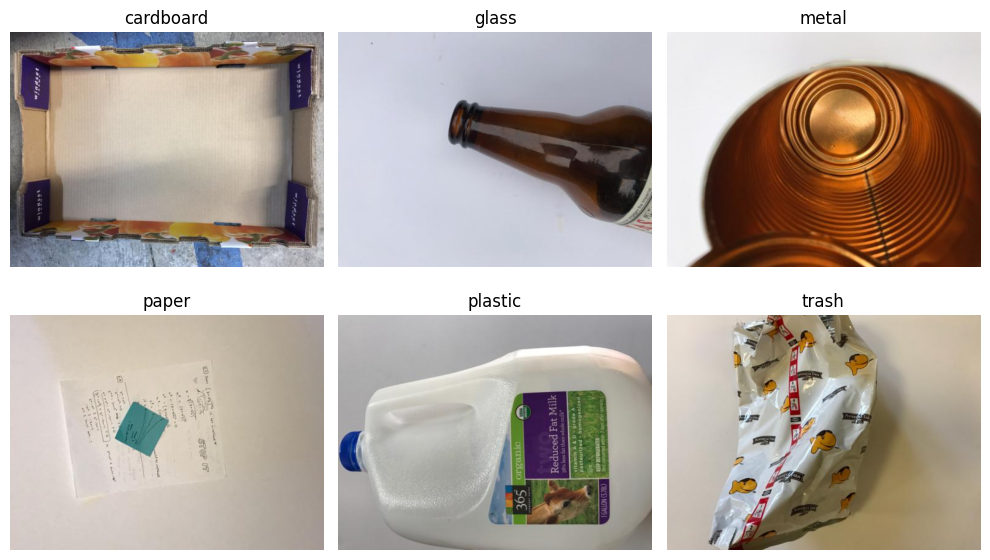

In [ ]:
plt.figure(figsize=(10, 6))

for i, category in enumerate(categories):
    folder = os.path.join(dataset_path, category)
    image_name = os.listdir(folder)[13]
    img_path = os.path.join(folder, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

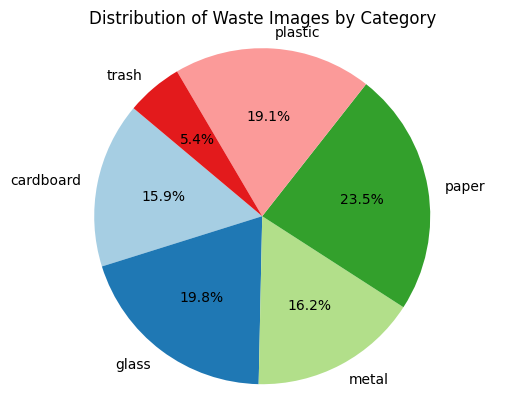

In [ ]:
class_counts = {}

for category in categories:
    folder = os.path.join(dataset_path, category)
    count = len(os.listdir(folder))
    class_counts[category] = count

#plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(),
        labels=class_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Paired.colors)
plt.title("Distribution of Waste Images by Category")
plt.axis('equal')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/archive/TrashType_Image_Dataset',
                                              target_size=(224, 224),
                                              batch_size=32,
                                              subset='training')

val_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/archive/TrashType_Image_Dataset',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
